config.yaml not found; using DEFAULT_CONFIG.
Aligned months: 86 (from 2018-11-30 to 2025-12-31)

=== Running simulations ===
Simulating: All-Equity 100/0
Simulating: Static 40/60
Simulating: Dynamic A (60/40→80/20↓20%,→40/60↑100%)
Simulating: Dynamic B (80/20→100/0↓10%,→60/40↑200%)

=== Strategy Summary ===

All-Equity 100/0
  mean: 80,387.88
median: 80,539.30
   std: 4,371.75
    p5: 73,084.54
   p25: 77,202.85
   p75: 83,107.53
   p95: 86,662.49

Static 40/60
  mean: 68,542.25
median: 68,486.52
   std: 2,966.96
    p5: 63,586.62
   p25: 66,772.89
   p75: 70,615.22
   p95: 73,067.30

Dynamic A (60/40→80/20↓20%,→40/60↑100%)
  mean: 72,770.27
median: 72,925.66
   std: 3,427.43
    p5: 66,980.64
   p25: 70,935.28
   p75: 74,946.08
   p95: 77,867.01

Dynamic B (80/20→100/0↓10%,→60/40↑200%)
  mean: 77,637.64
median: 77,829.12
   std: 4,210.36
    p5: 70,539.18
   p25: 74,919.08
   p75: 80,203.30
   p95: 83,841.02

=== Pairwise outperformance (B vs A) ===
                                   

C:\Users\YP836HV\AppData\Local\Temp\ipykernel_52892\1735561975.py:472: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",



Wrote files:
 - comparison_summary_spy_bnd_config.csv
 - pairwise_comparison_spy_bnd_config.csv
 - terminal_wealth_hist_spy_bnd_config.png
 - run_metadata.yaml
 - config_resolved.yaml


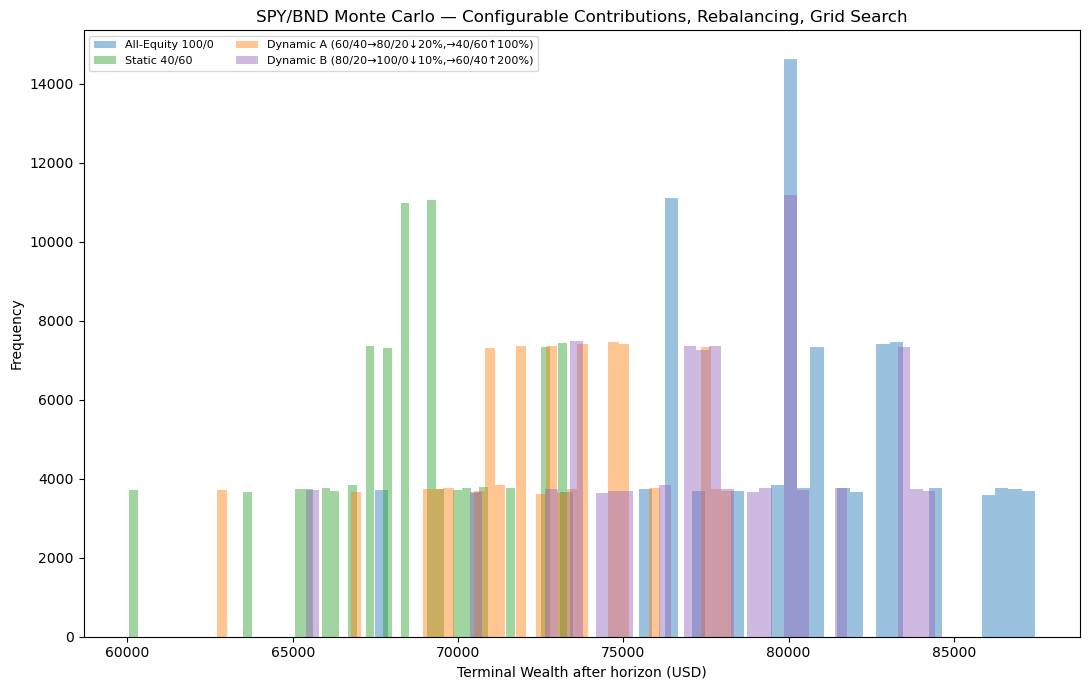

In [1]:
# SPY/BND total-return + Monte Carlo

# 0) GLOBAL SSL BYPASS (TEMPORARY)
import os, ssl, warnings, sys, subprocess, platform, hashlib, json
os.environ['REQUESTS_CA_BUNDLE'] = ''
os.environ['CURL_CA_BUNDLE']    = ''
ssl._create_default_https_context = ssl._create_unverified_context
import urllib3
warnings.filterwarnings("ignore", category=urllib3.exceptions.InsecureRequestWarning)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# 1) IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, time, datetime
from dataclasses import dataclass, asdict

# 1a) Optional YAML handling (safe fallback)
try:
    import yaml  # pip install pyyaml
    HAS_YAML = True
except Exception:
    HAS_YAML = False

def safe_dump_yaml(obj, path):
    """
    Dump YAML if PyYAML is available; else dump JSON and write a minimal YAML-like file.
    """
    if HAS_YAML:
        with open(path, "w", encoding="utf-8") as f:
            yaml.safe_dump(obj, f, sort_keys=False, allow_unicode=True)
    else:
        # JSON fallback
        base, ext = os.path.splitext(path)
        json_path = base + ".json"
        with open(json_path, "w", encoding="utf-8") as fjson:
            json.dump(obj, fjson, indent=2, ensure_ascii=False)
        # Minimal YAML-ish text (human readable)
        try:
            with open(path, "w", encoding="utf-8") as fy:
                fy.write("# YAML not available; this is a human-readable dump.\n")
                fy.write(json.dumps(obj, indent=2, ensure_ascii=False))
        except Exception:
            pass

# 2) CONFIG LOADING
DEFAULT_CONFIG = {
    "data": {
        "api_key": "XTKLMIAOG2UP3QDF",  # <-- REQUIRED, Get API KEY from "https://www.alphavantage.co/support/#api-key"
        "equity_symbol": "VT",         # SPDR S&P 500 ETF
        "bond_symbol": "BNDW",           # Vanguard Total Bond Market ETF
        "proxies": {},
        "verify_ssl": False
    },
    "simulation": {
        "months": 60,         # for 30 years
        "n_paths": 100000,       # Monte Carlo paths
        "block_size": 60,      # block-bootstrap length in months
        "seed": 42
    },
    "contributions": {
        "base_monthly": 1000.0,  # Contribute $1,000 every month
        "annual_raise": {"pct": 0.0, "apply_in_month": 1},
        "bonus_months": []  # list of {"month": int(1..12), "amount": float}
    },
    "rebalancing": {
        "enabled": False,
        "frequency": "annual",    # monthly|quarterly|annual
        "threshold_band": 0.00,   # if >0 rebalances only when drift exceeds band
        "method": "total"         # total|new_cash_only
    },
    "strategies": [
        {
            "name": "All-Equity 100/0",
            "baseline": [1.0, 0.0],
            "dynamic": None
        },
        {
            "name": "Static 40/60",
            "baseline": [0.40, 0.60],
            "dynamic": None
        },
        {
            "name": "Dynamic A (60/40→80/20↓20%,→40/60↑100%)",
            "baseline": [0.60, 0.40],
            "dynamic": {
                "dd_trigger": 0.20,         # 20% drawdown from peak
                "up_trigger_gain": 1.00,    # +100% from trough
                "down_weights": [0.80, 0.20],
                "up_weights":   [0.40, 0.60]
            }
        },
        {
            "name": "Dynamic B (80/20→100/0↓10%,→60/40↑200%)",
            "baseline": [0.80, 0.20],
            "dynamic": {
                "dd_trigger": 0.10,         # 10% drawdown
                "up_trigger_gain": 2.00,    # +200% from trough
                "down_weights": [1.00, 0.00],
                "up_weights":   [0.60, 0.40]
            }
        }
    ],
    "grid_search": {
        "enabled": False,
        "base_spec": {
            "name_prefix": "Grid Dyn",
            "baseline": [0.60, 0.40],
            "down_weights": [0.80, 0.20],
            "up_weights":   [0.40, 0.60]
        },
        "dd_trigger_range": [0.10, 0.30, 0.05],
        "up_trigger_gain_range": [0.50, 3.00, 0.50]
    }
}

def load_config(path="config.yaml"):
    if os.path.exists(path):
        if HAS_YAML:
            with open(path, "r", encoding="utf-8") as f:
                cfg = yaml.safe_load(f)
        else:
            # naive YAML-to-dict fallback: try JSON first
            try:
                with open(path, "r", encoding="utf-8") as f:
                    cfg = json.load(f)
            except Exception:
                print("PyYAML not installed; using DEFAULT_CONFIG. Install PyYAML for full YAML support.")
                cfg = DEFAULT_CONFIG.copy()
    else:
        print("config.yaml not found; using DEFAULT_CONFIG.")
        cfg = DEFAULT_CONFIG.copy()
    return cfg

CONFIG = load_config()

# 3) DATA DOWNLOAD (Alpha Vantage Monthly Adjusted -> total-return proxy)
def av_monthly_adjusted(symbol: str, api_key: str, proxies=None, verify=False,
                        max_retries=8, backoff=4):
    if not api_key or api_key.strip() == "" or "PASTE_YOUR" in api_key:
        raise RuntimeError("Alpha Vantage API key missing. Get one free at https://www.alphavantage.co/support/#api-key")

    url = "https://www.alphavantage.co/query"
    params = {"function": "TIME_SERIES_MONTHLY_ADJUSTED", "symbol": symbol, "apikey": api_key}

    last_status = None
    for attempt in range(max_retries):
        try:
            r = requests.get(url, params=params, proxies=proxies, verify=verify, timeout=30)
            last_status = r.status_code
        except Exception:
            time.sleep(backoff * (attempt + 1)); continue

        if r.status_code != 200:
            time.sleep(backoff * (attempt + 1)); continue

        data = r.json()
        if "Note" in data or "Information" in data or "Error Message" in data:
            time.sleep(backoff * (attempt + 1)); continue

        ts = data.get("Monthly Adjusted Time Series")
        if not ts:
            time.sleep(backoff * (attempt + 1)); continue

        idx = pd.to_datetime(list(ts.keys()))
        adj_close = pd.Series([float(v["5. adjusted close"]) for v in ts.values()],
                              index=idx).sort_index()
        if len(adj_close) < 24:
            time.sleep(backoff * (attempt + 1)); continue

        return adj_close

    raise RuntimeError(f"Alpha Vantage download failed for {symbol} after {max_retries} attempts "
                       f"(last HTTP status: {last_status}).")

print("Downloading monthly adjusted (total-return proxy) from Alpha Vantage...")
spy_px = av_monthly_adjusted(CONFIG["data"]["equity_symbol"], CONFIG["data"]["api_key"],
                             proxies=CONFIG["data"]["proxies"], verify=CONFIG["data"]["verify_ssl"])
bnd_px = av_monthly_adjusted(CONFIG["data"]["bond_symbol"], CONFIG["data"]["api_key"],
                             proxies=CONFIG["data"]["proxies"], verify=CONFIG["data"]["verify_ssl"])

# 4) RETURNS + ALIGN
def to_monthly_returns(px: pd.Series) -> pd.Series:
    px_m = px.resample("ME").last().dropna()
    r = px_m.pct_change().dropna().clip(lower=-0.99)  # avoid <-100%
    return r

df_ret = pd.DataFrame({
    "spy": to_monthly_returns(spy_px),
    "bnd": to_monthly_returns(bnd_px)
}).dropna()
spy_r, bnd_r = df_ret["spy"], df_ret["bnd"]
print(f"Aligned months: {len(spy_r)} (from {spy_r.index.min().date()} to {spy_r.index.max().date()})")

# 5) CONTRIBUTION SCHEDULE
def make_contrib_vector(months: int, base: float, annual_raise_pct: float = 0.0,
                        apply_in_month: int = 1, bonus_months=None) -> np.ndarray:
    """
    Returns an array of monthly contributions, with annual raises and bonus injections.
    apply_in_month: 1..12 (month number within each calendar year)
    bonus_months: list of dicts {"month": int(1..12), "amount": float}
    """
    if bonus_months is None:
        bonus_months = []
    contrib = np.zeros(months)
    base_current = base
    for t in range(months):
        # Calendar month within year (1..12)
        cal_m = (t % 12) + 1
        # Apply base contribution
        contrib[t] += base_current
        # Add bonus if configured for this calendar month
        for bm in bonus_months:
            if bm.get("month") == cal_m:
                contrib[t] += float(bm.get("amount", 0.0))
        # If this is the raise month and not the last month, increase base for next months
        if cal_m == apply_in_month and annual_raise_pct and t < months - 1:
            base_current *= (1.0 + annual_raise_pct)
    return contrib

CONTRIB = make_contrib_vector(
    months=CONFIG["simulation"]["months"],
    base=CONFIG["contributions"]["base_monthly"],
    annual_raise_pct=CONFIG["contributions"]["annual_raise"].get("pct", 0.0),
    apply_in_month=int(CONFIG["contributions"]["annual_raise"].get("apply_in_month", 1)),
    bonus_months=CONFIG["contributions"].get("bonus_months", [])
)

# 6) BLOCK-BOOTSTRAP (joint)
def block_bootstrap_joint(r_e: pd.Series, r_b: pd.Series, n_months=int(CONFIG["simulation"]["months"]), block=int(CONFIG["simulation"]["block_size"]), seed=None):
    if seed is not None:
        np.random.seed(seed)
    df = pd.DataFrame({"re": r_e, "rb": r_b}).dropna()
    N = len(df)
    if N < block:
        raise ValueError(f"History length {N} < block size {block}.")
    max_start = N - block

    chunks = []
    while sum(map(len, chunks)) < n_months:
        s = np.random.randint(0, max_start + 1)
        chunks.append(df.iloc[s:s + block])
    boot = pd.concat(chunks, axis=0).iloc[:n_months]
    return boot["re"].to_numpy(), boot["rb"].to_numpy()

# 7) STRATEGY SPEC
@dataclass
class StrategySpec:
    name: str
    baseline: tuple                  # (w_e, w_b) for NEW contributions
    dd_trigger: float = None         # drawdown threshold from peak
    up_trigger_gain: float = None    # gain from trough (multiple)
    down_weights: tuple = None       # weights when drawdown condition met
    up_weights: tuple = None         # weights when recovery condition met

# 7a) Rebalancing helpers
def is_rebalance_month(t, frequency: str) -> bool:
    # t is 0-based month index
    if frequency == "monthly":
        return True
    elif frequency == "quarterly":
        return ((t + 1) % 3) == 0
    elif frequency == "annual":
        return ((t + 1) % 12) == 0
    return False

def rebalance(eq_val: float, bd_val: float, target_w: tuple, threshold_band: float):
    """
    Rebalance to target weights if drift exceeds threshold_band.
    Returns (new_eq_val, new_bd_val).
    """
    total = eq_val + bd_val
    if total <= 0:
        return eq_val, bd_val
    current_w_e = eq_val / total
    drift = abs(current_w_e - target_w[0])
    if threshold_band and drift <= threshold_band:
        return eq_val, bd_val
    # Full rebalance to target weights
    return total * target_w[0], total * target_w[1]

# 8) SIMULATOR (supports dynamic rules, contribution schedule, optional rebalancing)
def simulate_strategy(r_e_hist: pd.Series, r_b_hist: pd.Series, spec: StrategySpec,
                      months: int, n_paths: int, block: int, seed: int,
                      contrib_vec: np.ndarray,
                      rebalance_cfg: dict):
    results = np.zeros(n_paths)
    is_dynamic = spec.dd_trigger is not None and spec.up_trigger_gain is not None

    for i in range(n_paths):
        re, rb = block_bootstrap_joint(r_e_hist, r_b_hist, n_months=months, block=block, seed=seed + i)

        # Equity price index for triggers
        Pe = np.full(months + 1, 100.0)
        for t in range(months):
            Pe[t + 1] = Pe[t] * (1 + re[t])

        last_peak   = 100.0
        last_trough = 100.0

        eq = 0.0; bd = 0.0

        for t in range(months):
            # Decide weights for NEW contribution at start-of-month
            w_e, w_b = spec.baseline
            if is_dynamic:
                P_now = Pe[t]
                last_peak = max(last_peak, P_now)
                drawdown = P_now / last_peak - 1.0
                # trough updates only during bear phases
                if drawdown <= -spec.dd_trigger:
                    last_trough = min(last_trough, P_now)
                cond_down = (P_now <= (1.0 - spec.dd_trigger) * last_peak)
                cond_up   = (P_now >= (1.0 + spec.up_trigger_gain) * last_trough)
                if cond_down and spec.down_weights is not None:
                    w_e, w_b = spec.down_weights
                elif cond_up and spec.up_weights is not None:
                    w_e, w_b = spec.up_weights

            # Add new cash for month t
            eq += contrib_vec[t] * w_e
            bd += contrib_vec[t] * w_b

            # Optional rebalancing BEFORE applying returns (typical implementation)
            if rebalance_cfg.get("enabled", False):
                freq = rebalance_cfg.get("frequency", "annual")
                method = rebalance_cfg.get("method", "total")
                band = float(rebalance_cfg.get("threshold_band", 0.0))
                target_w = (w_e, w_b)  # rebalance to current month's intended weights
                if is_rebalance_month(t, freq):
                    if method == "total":
                        eq, bd = rebalance(eq, bd, target_w, band)
                    elif method == "new_cash_only":
                        # No existing holdings moved; 'band' ignored
                        pass

            # Apply returns for the month
            eq *= (1 + re[t])
            bd *= (1 + rb[t])

        results[i] = eq + bd

    return results

def summarize(x: np.ndarray):
    return {
        "mean":   float(np.mean(x)),
        "median": float(np.median(x)),
        "std":    float(np.std(x, ddof=1)),
        "p5":     float(np.percentile(x, 5)),
        "p25":    float(np.percentile(x, 25)),
        "p75":    float(np.percentile(x, 75)),
        "p95":    float(np.percentile(x, 95))
    }

# 9) STRATEGY LIST + GRID GENERATION
def parse_strategies_from_config(cfg):
    specs = []
    for s in cfg.get("strategies", []):
        dyn = s.get("dynamic")
        spec = StrategySpec(
            name=s["name"],
            baseline=tuple(s["baseline"]),
            dd_trigger=None if dyn is None else dyn.get("dd_trigger"),
            up_trigger_gain=None if dyn is None else dyn.get("up_trigger_gain"),
            down_weights=None if dyn is None else tuple(dyn.get("down_weights")),
            up_weights=None if dyn is None else tuple(dyn.get("up_weights"))
        )
        specs.append(spec)

    # Grid search expansion
    gs = cfg.get("grid_search", {})
    if gs.get("enabled", False):
        base = gs.get("base_spec", {})
        name_prefix = base.get("name_prefix", "Grid Dyn")
        baseline = tuple(base.get("baseline", [0.60, 0.40]))
        down_w   = tuple(base.get("down_weights", [0.80, 0.20]))
        up_w     = tuple(base.get("up_weights",   [0.40, 0.60]))
        dd_start, dd_end, dd_step = gs.get("dd_trigger_range", [0.10, 0.30, 0.05])
        up_start, up_end, up_step = gs.get("up_trigger_gain_range", [0.50, 3.00, 0.50])

        dd_vals = np.round(np.arange(dd_start, dd_end + 1e-9, dd_step), 3)
        up_vals = np.round(np.arange(up_start, up_end + 1e-9, up_step), 3)
        for dd in dd_vals:
            for ug in up_vals:
                specs.append(StrategySpec(
                    name=f"{name_prefix} dd={dd:.2f}, up={ug:.2f}",
                    baseline=baseline,
                    dd_trigger=float(dd),
                    up_trigger_gain=float(ug),
                    down_weights=down_w,
                    up_weights=up_w
                ))
    return specs

strategies = parse_strategies_from_config(CONFIG)

# 10) RUN & SUMMARIZE
months     = int(CONFIG["simulation"]["months"])
n_paths    = int(CONFIG["simulation"]["n_paths"])
block      = int(CONFIG["simulation"]["block_size"])
seed       = int(CONFIG["simulation"]["seed"])
rebal_cfg  = CONFIG.get("rebalancing", {})

all_results = {}
summaries = []
print("\n=== Running simulations ===")
for spec in strategies:
    print(f"Simulating: {spec.name}")
    res = simulate_strategy(spy_r, bnd_r, spec, months, n_paths, block, seed, CONTRIB, rebal_cfg)
    all_results[spec.name] = res
    sm = summarize(res); sm["strategy"] = spec.name
    summaries.append(sm)

df_summary = pd.DataFrame(summaries).set_index("strategy")
summary_csv = "comparison_summary_spy_bnd_config.csv"
df_summary.to_csv(summary_csv)

print("\n=== Strategy Summary ===")
for name in df_summary.index:
    sm = df_summary.loc[name]
    print(f"\n{name}")
    for k in ["mean","median","std","p5","p25","p75","p95"]:
        print(f"{k:>6}: {sm[k]:,.2f}")

# 11) PAIRWISE COMPARISON
pairs = []
names = list(all_results.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        A, B = all_results[a], all_results[b]
        pairs.append({
            "A": a, "B": b,
            "prob_B_outperforms_A": float(np.mean(B > A)),
            "avg_B_minus_A": float(np.mean(B - A)),
            "median_B_minus_A": float(np.median(B - A))
        })
df_pairs = pd.DataFrame(pairs)
pairs_csv = "pairwise_comparison_spy_bnd_config.csv"
df_pairs.to_csv(pairs_csv, index=False)

print("\n=== Pairwise outperformance (B vs A) ===")
print(df_pairs.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))

# 12) PLOT
plt.figure(figsize=(11,7))
colors = ["#1f77b4","#2ca02c","#ff7f0e","#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
for (name, res), c in zip(all_results.items(), colors * ((len(all_results)//len(colors))+1)):
    plt.hist(res, bins=50, alpha=0.45, label=name, color=c)
plt.xlabel("Terminal Wealth after horizon (USD)")
plt.ylabel("Frequency")
plt.title("SPY/BND Monte Carlo — Configurable Contributions, Rebalancing, Grid Search")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plot_png = "terminal_wealth_hist_spy_bnd_config.png"
plt.savefig(plot_png, dpi=160)

# 13) METADATA & AUDIT LOGGING (YAML + resolved config dump)
def git_commit_hash():
    try:
        return subprocess.check_output(["git", "rev-parse", "HEAD"], stderr=subprocess.DEVNULL).decode("utf-8").strip()
    except Exception:
        return None

def config_hash(cfg):
    s = json.dumps(cfg, sort_keys=True)
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

run_meta = {
    "timestamp_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "python_version": sys.version,
    "platform": platform.platform(),
    "git_commit": git_commit_hash(),
    "script": os.path.basename(__file__) if "__file__" in globals() else "spy_bnd_montecarlo_configurable.py",
    "data": {
        "equity_symbol": CONFIG["data"]["equity_symbol"],
        "bond_symbol": CONFIG["data"]["bond_symbol"],
        "verify_ssl": CONFIG["data"]["verify_ssl"],
        "proxies_present": bool(CONFIG["data"]["proxies"])
    },
    "simulation": CONFIG["simulation"],
    "rebalancing": CONFIG["rebalancing"],
    "strategies_count": len(strategies),
    "grid_search_enabled": CONFIG.get("grid_search", {}).get("enabled", False),
    "contributions": CONFIG["contributions"],
    "outputs": {
        "summary_csv": summary_csv,
        "pairs_csv": pairs_csv,
        "histogram_png": plot_png,
        "resolved_config_yaml": "config_resolved.yaml"
    },
    "config_hash_sha256": config_hash(CONFIG)
}
safe_dump_yaml(run_meta, "run_metadata.yaml")
safe_dump_yaml(CONFIG, "config_resolved.yaml")

print("\nWrote files:")
print(f" - {summary_csv}")
print(f" - {pairs_csv}")
print(f" - {plot_png}")
print(" - run_metadata.yaml")
print(" - config_resolved.yaml")
